# Installing required libraries

In [39]:
# %pip install numpy
# %pip install pandas
# %pip install matplotlib
# %pip install seaborn
# %pip install scipy

# I. Đọc dữ liệu

In [40]:
from preprocessor.sklearn_preprocessor import preprocess_data
from featureEngineering.Visualizer import Visualizer
from featureEngineering.FeatureSelection import FeatureSelection

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [41]:
path = './data/'
data = pd.read_csv(path + 'train.csv')

In [42]:
print(f'Số lượng dòng của data: {len(data)}')
print(data.columns)

Số lượng dòng của data: 1647
Index(['Make', 'Model', 'Price', 'Year', 'Kilometer', 'Fuel Type',
       'Transmission', 'Location', 'Color', 'Owner', 'Seller Type', 'Engine',
       'Max Power', 'Max Torque', 'Drivetrain', 'Length', 'Width', 'Height',
       'Seating Capacity', 'Fuel Tank Capacity'],
      dtype='object')


In [43]:
data.head()

,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,Seller Type,Engine,Max Power,Max Torque,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity
0,BMW,3-Series 320d,800000,2012,75576,Diesel,Automatic,Mumbai,White,Second,Individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BMW,X1 sDrive20d xLine,2199000,2016,77000,Diesel,Automatic,Surat,Black,First,Individual,1995 cc,184 bhp @ 4000 rpm,350 Nm @ 1750 rpm,RWD,4454.0,2044.0,1545.0,5.0,63.0
2,Mahindra,XUV500 W4 1.99,800000,2017,112000,Diesel,Manual,Muzaffurpur,Silver,First,Individual,1997 cc,138 bhp @ 3750 rpm,320 Nm @ 1600 rpm,FWD,4585.0,1890.0,1785.0,7.0,70.0
3,Mercedes-Benz,GLS 400d 4MATIC,12900000,2021,3000,Diesel,Automatic,Delhi,White,First,Individual,2925 cc,326 bhp @ 3600 rpm,700 Nm @ 1200 rpm,AWD,5207.0,2157.0,1823.0,7.0,90.0
4,Toyota,Fortuner 2.8 4x2 AT [2016-2020],3499000,2019,73000,Diesel,Automatic,Mumbai,White,First,Individual,2755 cc,174 bhp @ 3400 rpm,450 Nm @ 1600 rpm,RWD,4795.0,1855.0,1835.0,7.0,80.0


# II. Tiền xử lý dữ liệu

## 1. Cleaning data


In [44]:
def clean_data(data):
    data["Engine"] = data["Engine"].str.replace(' cc', '', regex=False).astype(float)

    data[['Max Power BHP', 'Max Power RPM']] = data['Max Power'].str.extract(r'(\d+)\s*bhp\s*@\s*(\d+)\s*rpm')
    data['Max Power BHP'] = pd.to_numeric(data['Max Power BHP'], errors='coerce')
    data['Max Power RPM'] = pd.to_numeric(data['Max Power RPM'], errors='coerce')

    data[['Max Torque Nm', 'Max Torque RPM']] = data['Max Torque'].str.extract(r'(\d+)\s*Nm\s*@\s*(\d+)\s*rpm')
    data['Max Torque Nm'] = pd.to_numeric(data['Max Torque Nm'], errors='coerce')
    data['Max Torque RPM'] = pd.to_numeric(data['Max Torque RPM'], errors='coerce')

    rare_fuel_types = ['Electric', 'LPG', 'Hybrid', 'CNG + CNG', 'Petrol + LPG']
    data["Fuel Type"] = data["Fuel Type"].apply(lambda x: 'Others' if x in rare_fuel_types else x)

    drop_columns = ['Make', 'Model', 'Location', 'Color', 'Max Power', 'Max Torque']
    data.drop(drop_columns, axis=1, inplace=True)
    
    return data

In [45]:
data = clean_data(data)

## 2. Splitting and preprocessing

In [46]:
# Apply splitting and preprocessing
train_df, test_df, preprocessor, feature_names = preprocess_data(
    data=data,
    save_path='./processed_data/',
    train_ratio=0.8,
    test_ratio=0.2,
)

In [47]:
# Check if there are any columns with object type in the transformed dataframes
print("Train DataFrame Object Types:", train_df.select_dtypes(include=['object']).columns.tolist())
print("Test DataFrame Object Types:", test_df.select_dtypes(include=['object']).columns.tolist())

# If there are object columns, convert them to numeric
for df in [train_df, test_df]:
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = pd.to_numeric(df[col])

# Verify the conversion worked
print("\nAfter conversion:")
print("Train DataFrame Types:", train_df.dtypes.value_counts())
print("Test DataFrame Types:", test_df.dtypes.value_counts())

Train DataFrame Object Types: []
Test DataFrame Object Types: []

After conversion:
Train DataFrame Types: float64    22
Name: count, dtype: int64
Test DataFrame Types: float64    22
Name: count, dtype: int64


# III. Modeling

## 1. Chọn các cột đặc trưng

In [48]:
from modelling.Model import StandardRegression, PolynomialRegression

oneHotCols = ['Drivetrain', 'Fuel Type', 'Seller Type', 'Transmission']
model_type = StandardRegression
model = model_type()

train = model.transform_features(train_df)
test = model.transform_features(test_df)
corr = train.corr()
sort_order = corr['Price'].abs().sort_values(ascending=False).index
sorted_corr = corr.loc[sort_order, sort_order]
subcols = sorted_corr.index.tolist()

# Chọn thử 14 cột có abs correlation >= 0.3 sau khi visualize
subcols = subcols[:14]
subtract = ['Fuel Type_Petrol', 'Fuel Type_Diesel', 'Price']
subcols = list(set(subcols) - set(subtract))
add = []
subcols = subcols + add
subcols

['Drivetrain_FWD',
 'Max Power RPM',
 'Transmission_Manual',
 'Length',
 'Fuel Tank Capacity',
 'Max Torque RPM',
 'Drivetrain_RWD',
 'Engine',
 'Max Power BHP',
 'Year',
 'Width']

In [49]:
print('Các cột đã bỏ:')
set(train_df.columns) - set(subcols)

Các cột đã bỏ:


{'Fuel Type_Diesel',
 'Fuel Type_Others',
 'Fuel Type_Petrol',
 'Height',
 'Kilometer',
 'Max Torque Nm',
 'Owner',
 'Price',
 'Seating Capacity',
 'Seller Type_Corporate',
 'Seller Type_Individual'}

In [50]:

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
def testing(subcols=None, linear=True, deg=2, auto_selection = True, model_type=None, plot=True):
    if subcols is None:
        subcols = train_df.drop('Price', axis=1).columns.to_list()
        
    if linear:
        model = StandardRegression()
    else:
        model = model_type(degree=deg)

    train = model.transform_features(train_df.drop('Price', axis=1))
    test = model.transform_features(test_df.drop('Price', axis=1))
    train['Price'] = train_df['Price']
    test['Price'] = test_df['Price']

    # Forward selection
    if auto_selection:
        if len(subcols) <= 15:
            subcols, r2 = FeatureSelection.subset_selection(
                train[subcols + ['Price']],
                test[subcols + ['Price']],
                target='Price',
                model = model
            )
        else:
            subcols, r2 = FeatureSelection.forward_selection_r2(
                train[subcols + ['Price']],
                oneHotCols=oneHotCols,
                target='Price',
                model = model
            )
        print('Adjusted log r^2 on transformed target:', r2)
        print('Eliminated features:', set(train.columns.to_list()) - set(subcols))
    
    print('Chosed columns: ', subcols)
    print('Total columns: ', len(subcols))

    if(plot):
        model.fit(train[subcols], train['Price'])
        y_train = np.exp(train['Price'])
        y_test = np.exp(test['Price'])
        y_train_pred = np.exp(model.predict(train[subcols]))
        y_test_pred = np.exp(model.predict(test[subcols]))

        # Evaluate after selecting features
        print('Train r^2: ', r2_score(y_train, y_train_pred))
        print('Train MAE: ', f"{mean_absolute_error(y_train, y_train_pred):.3e}")
        print('Train MSE: ', f"{mean_squared_error(y_train, y_train_pred):.3e}")

        print('Test r^2: ', r2_score(y_test, y_test_pred))
        print('Test MAE: ', f"{mean_absolute_error(y_test, y_test_pred):.3e}")
        print('Test MSE: ', f"{mean_squared_error(y_test, y_test_pred):.3e}")

        # diagnostic plots
        Visualizer.pred_vs_true_plot(y_train, y_train_pred, y_test, y_test_pred, figsize=(15, 5))
        Visualizer.residual_plot([y_train, y_train_pred], [y_test, y_test_pred])
        Visualizer.qq_plot((y_train, y_train_pred), (y_test, y_test_pred))
        Visualizer.scale_location_plot((y_train, y_train_pred), (y_test, y_test_pred))

    return subcols

## 2. So sánh mô hình

### Linear regression (with chosen columns correlated > 0.3)
$$y =  \beta_0 + \sum_{j=1}^{11} \beta_j * x_j\\ \overline{1..11} \text{ is the subset of chosed columns} $$

Chosed columns:  ['Drivetrain_FWD', 'Max Power RPM', 'Transmission_Manual', 'Length', 'Fuel Tank Capacity', 'Max Torque RPM', 'Drivetrain_RWD', 'Engine', 'Max Power BHP', 'Year', 'Width']
Total columns:  11
Train r^2:  0.7934050313486871
Train MAE:  4.113e+05
Train MSE:  1.265e+12
Test r^2:  0.8369645347878696
Test MAE:  3.256e+05
Test MSE:  6.251e+11


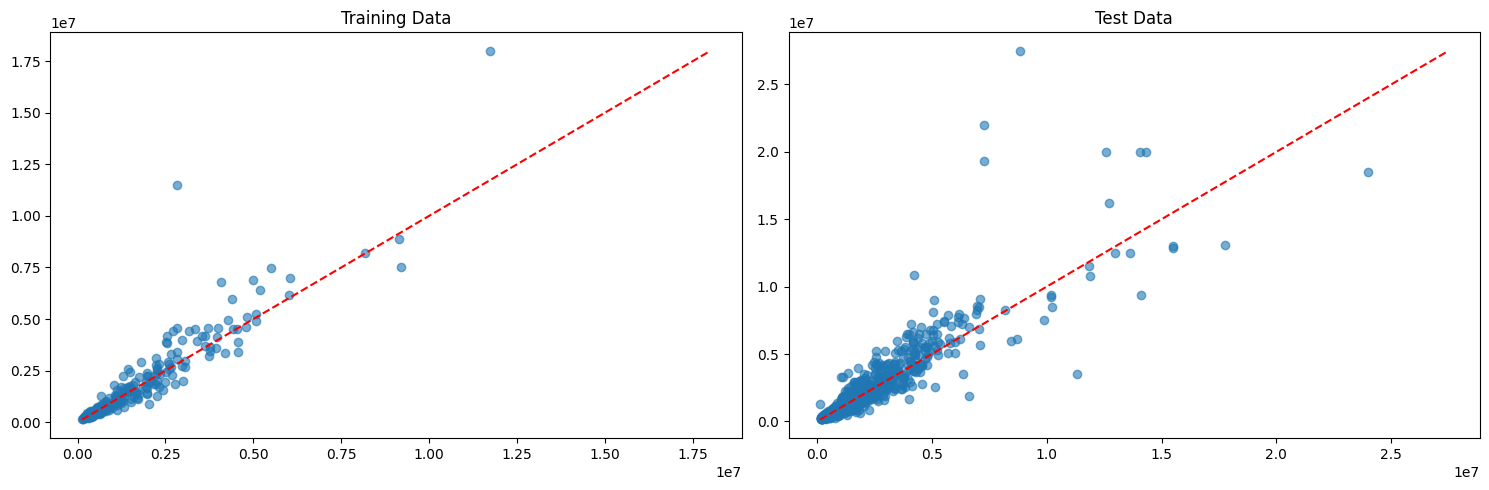

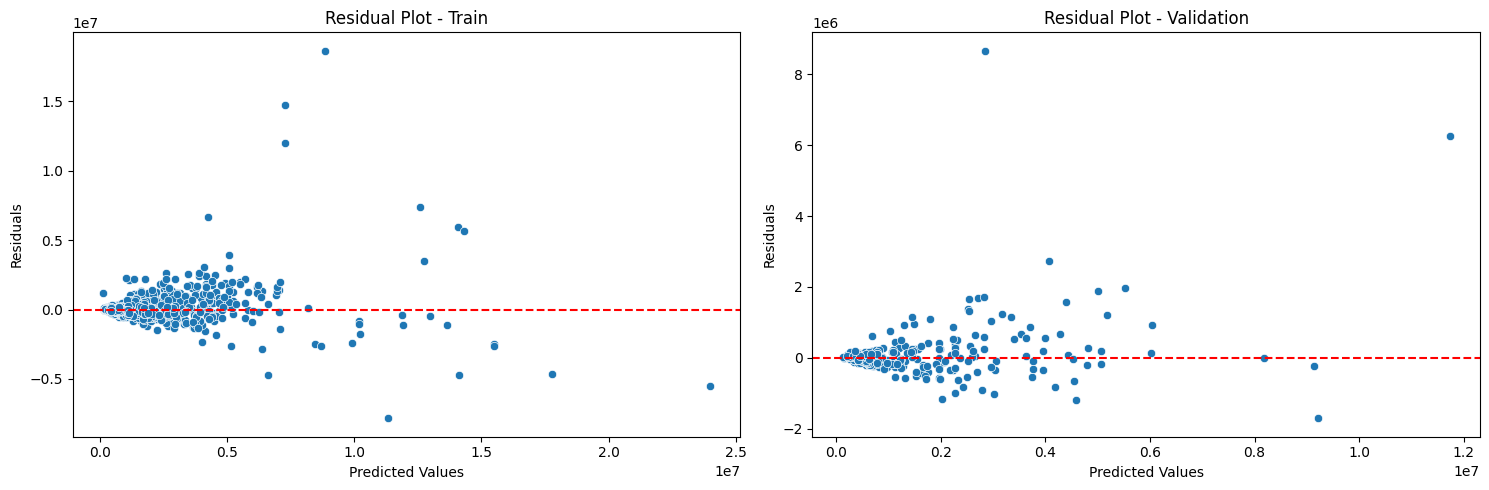

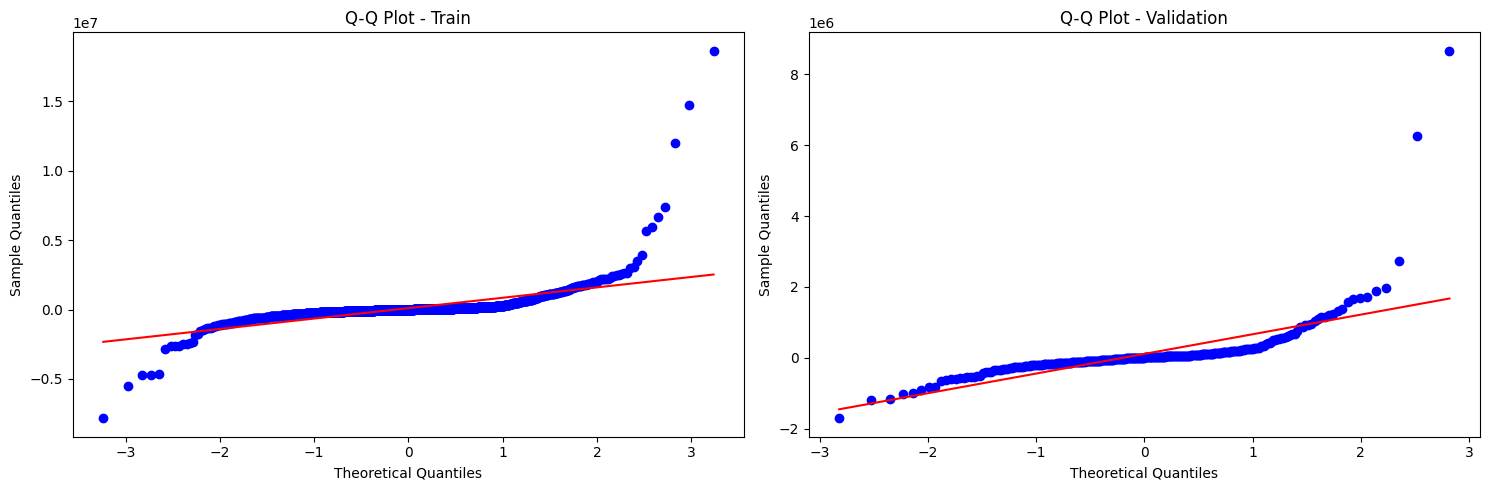

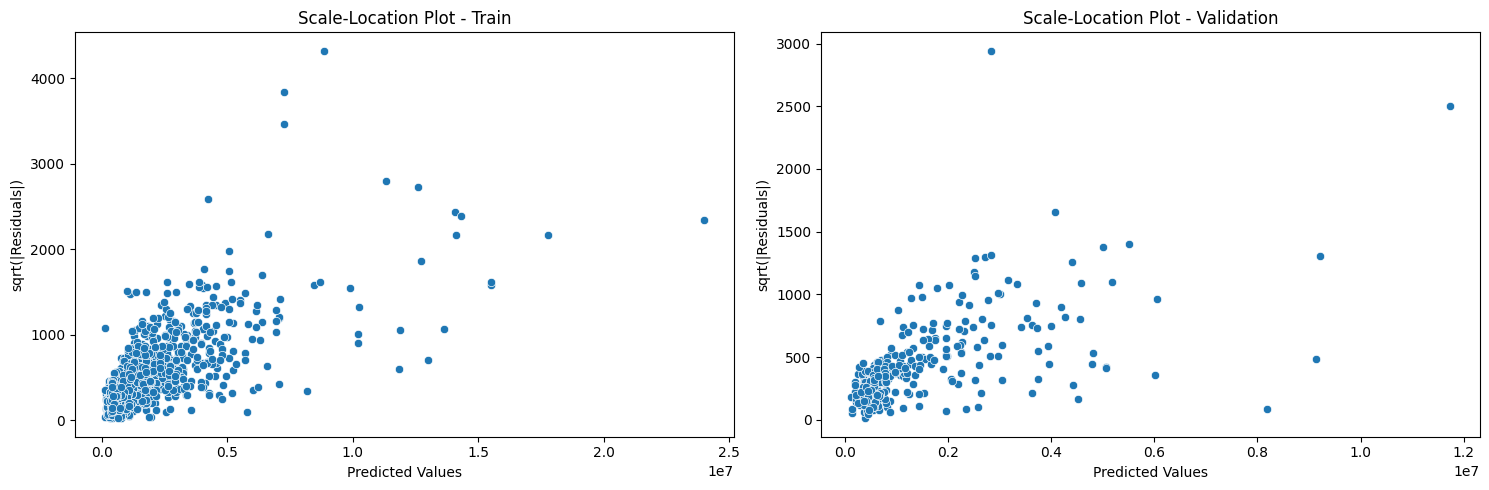

['Drivetrain_FWD',
 'Max Power RPM',
 'Transmission_Manual',
 'Length',
 'Fuel Tank Capacity',
 'Max Torque RPM',
 'Drivetrain_RWD',
 'Engine',
 'Max Power BHP',
 'Year',
 'Width']

In [51]:
testing(subcols=subcols, linear=True, auto_selection=False)

### Linear regression with auto feature selection
$$ y =  \beta_0 + \sum_{j=1}^n \beta_j * x_j\\ \overline{1..n} \text{ is the subset of chosed columns by performing feature selection on dataset $D$ (adjusted-$R^2$)} $$

Adjusted log r^2 on transformed target: 0.9235374565651404
Eliminated features: {'Engine', 'Price'}
Chosed columns:  ['Max Power BHP', 'Year', 'Length', 'Transmission_Manual', 'Max Power RPM', 'Fuel Tank Capacity', 'Seating Capacity', 'Drivetrain_FWD', 'Drivetrain_RWD', 'Kilometer', 'Width', 'Fuel Type_Diesel', 'Fuel Type_Others', 'Fuel Type_Petrol', 'Max Torque RPM', 'Height', 'Max Torque Nm', 'Seller Type_Corporate', 'Seller Type_Individual', 'Owner']
Total columns:  20
Train r^2:  0.8281197241097666
Train MAE:  3.711e+05
Train MSE:  1.053e+12
Test r^2:  0.8941664635200263
Test MAE:  2.962e+05
Test MSE:  4.058e+11


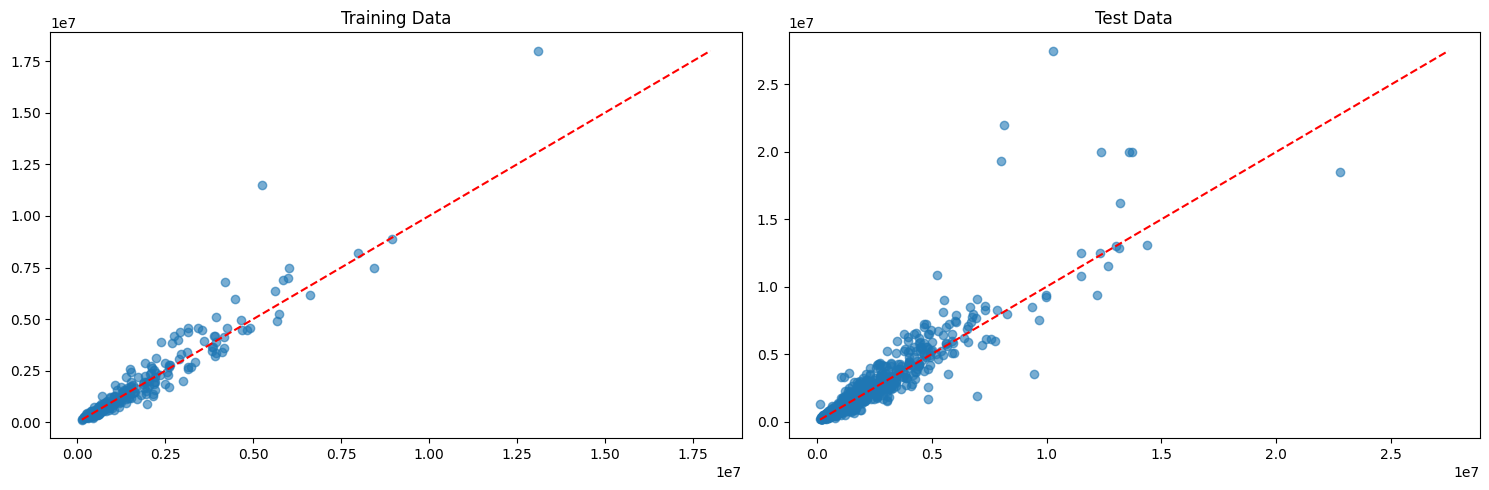

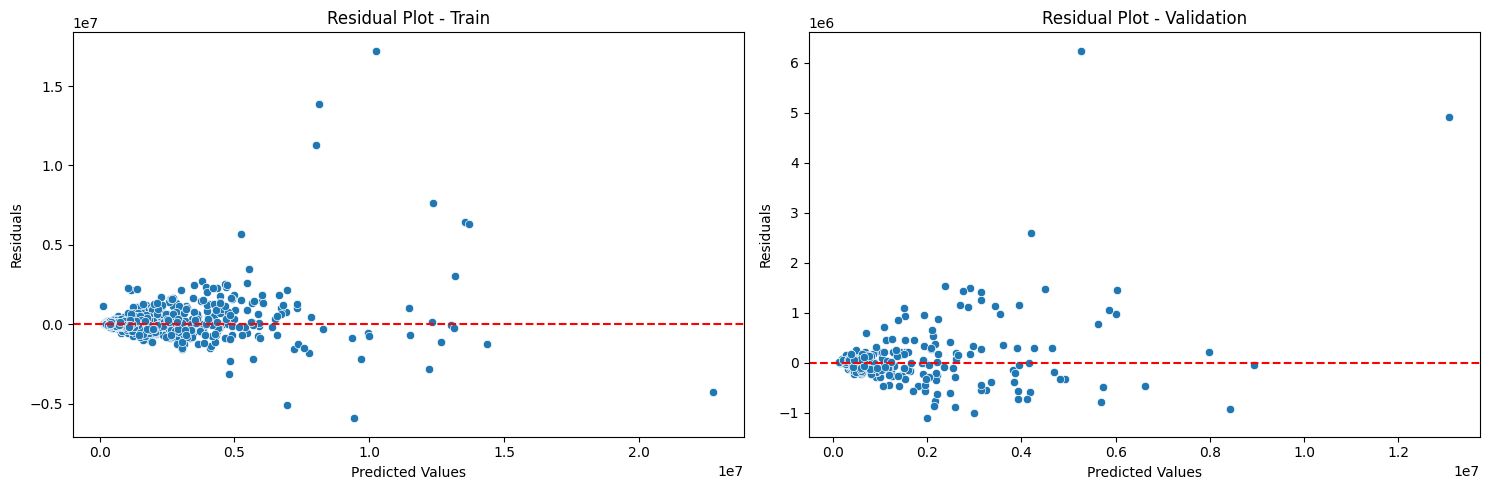

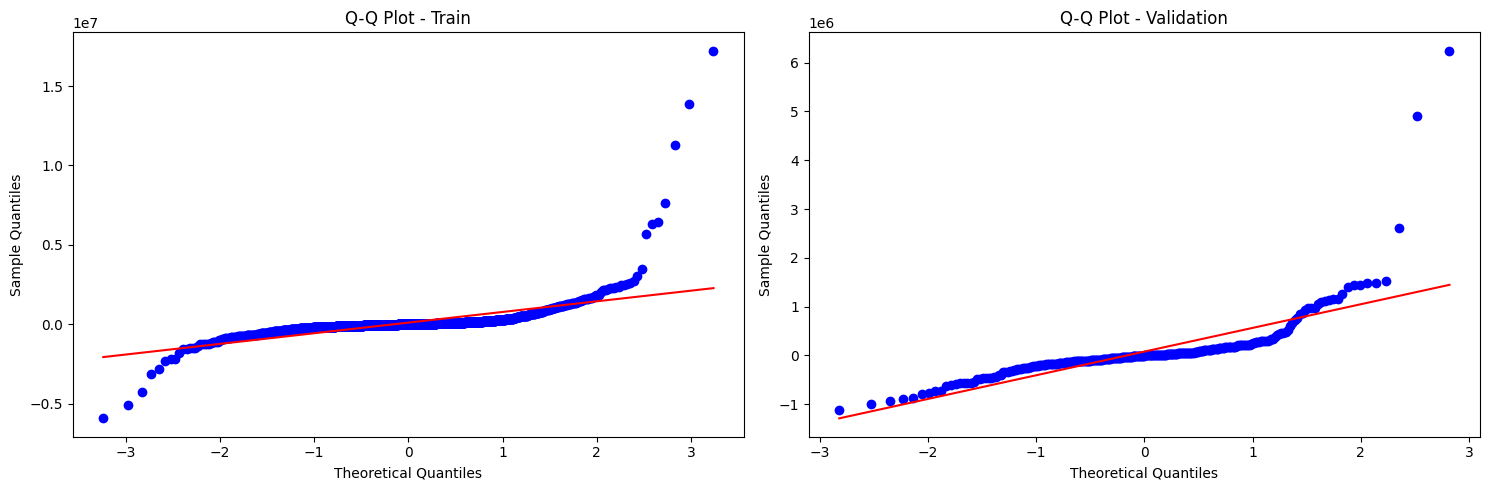

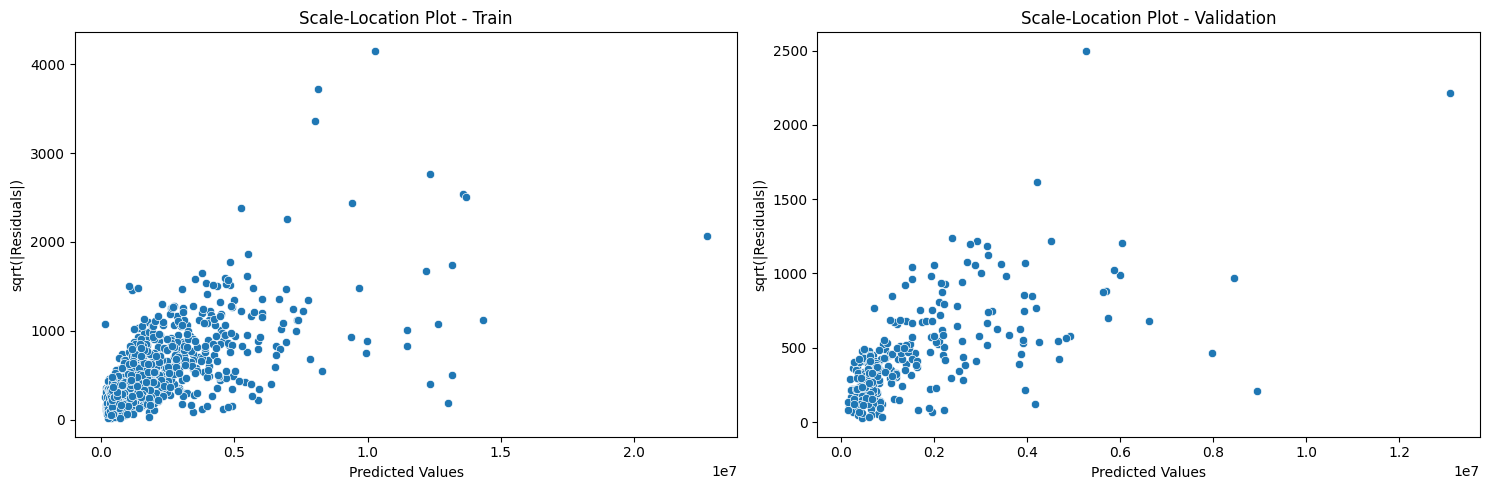

['Max Power BHP',
 'Year',
 'Length',
 'Transmission_Manual',
 'Max Power RPM',
 'Fuel Tank Capacity',
 'Seating Capacity',
 'Drivetrain_FWD',
 'Drivetrain_RWD',
 'Kilometer',
 'Width',
 'Fuel Type_Diesel',
 'Fuel Type_Others',
 'Fuel Type_Petrol',
 'Max Torque RPM',
 'Height',
 'Max Torque Nm',
 'Seller Type_Corporate',
 'Seller Type_Individual',
 'Owner']

In [52]:
testing(auto_selection=True)

### Polynomial regression (degree = 2)
$$ y = \beta_0 + \sum_{j=1}^p \beta_j x_j + \sum_{j=1}^p \beta_{j+p} x_j^2 + ... + \sum_{j=1}^p \beta_{j+(d-1)p} x_j^d + \varepsilon \\ \text{n is the number of predictors and d is the chosen degree of polynomial regression} \\ \overline{1..n} \text{ is the subset of chosed columns by performing feature selection on dataset $D$ (adjusted-$R^2$)} $$

Adjusted log r^2 on transformed target: 0.9320184447320433
Eliminated features: {'Max Torque RPM^2', 'Width^2', 'Max Power BHP^2', 'Seating Capacity^2', 'Seller Type_Individual^2', 'Kilometer^2', 'Engine', 'Length^2', 'Drivetrain_RWD^2', 'Fuel Type_Diesel^2', 'Year^2', 'Fuel Tank Capacity^2', 'Drivetrain_FWD^2', 'Height^2', 'Owner^2', 'Max Power RPM^2', 'Transmission_Manual^2', 'Max Torque Nm^2', 'Engine^2', 'Fuel Type_Others^2', 'Price', 'Seller Type_Corporate^2', 'Fuel Type_Petrol^2'}
Chosed columns:  ['Max Power BHP', 'Year', 'Max Torque Nm', 'Transmission_Manual', 'Length', 'Fuel Tank Capacity', 'Seating Capacity', 'Max Torque RPM', 'Kilometer', 'Width', 'Fuel Type_Diesel', 'Fuel Type_Others', 'Fuel Type_Petrol', 'Drivetrain_FWD', 'Drivetrain_RWD', 'Height', 'Max Power RPM', 'Owner', 'Seller Type_Corporate', 'Seller Type_Individual']
Total columns:  20
Train r^2:  0.8223877652392293
Train MAE:  3.637e+05
Train MSE:  1.088e+12
Test r^2:  0.8276497292724239
Test MAE:  3.141e+05
Test 

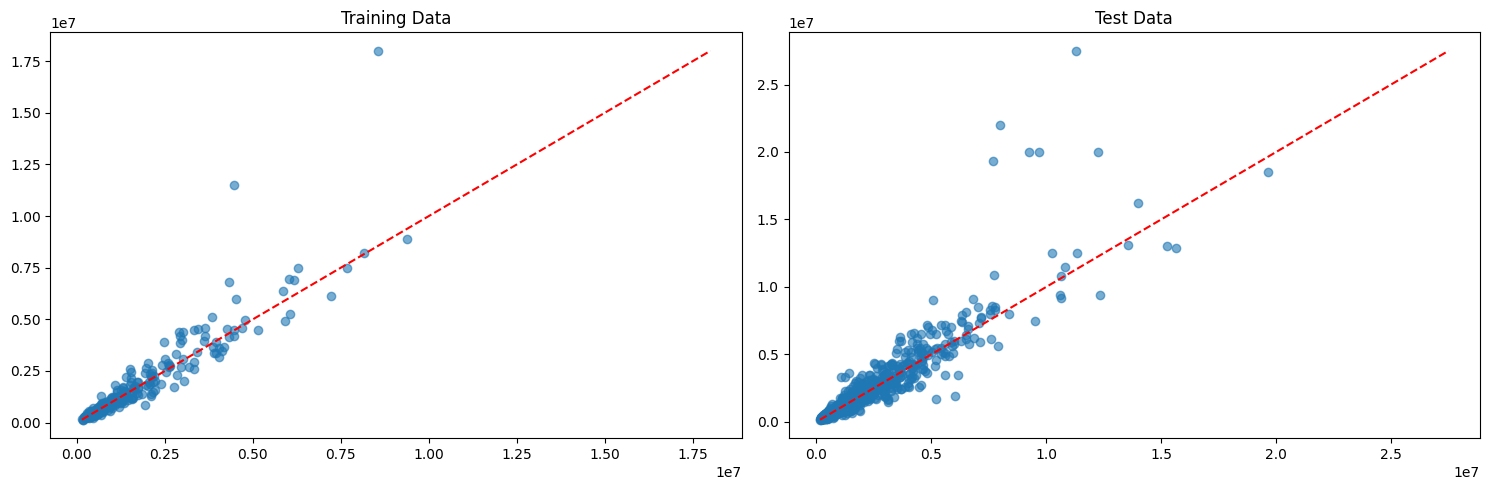

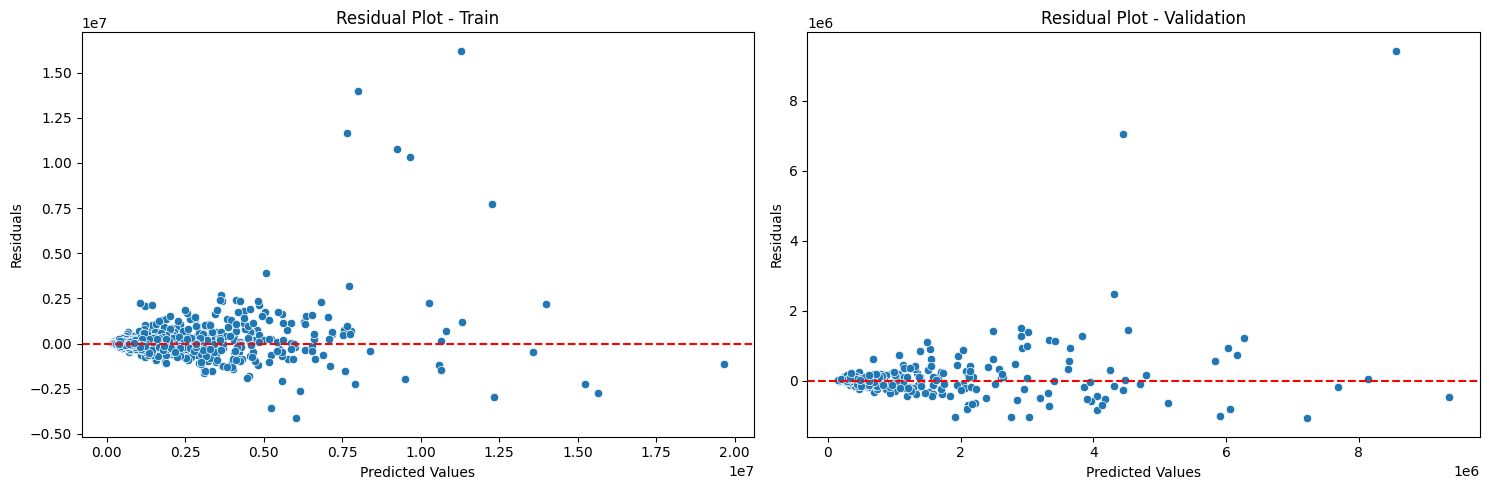

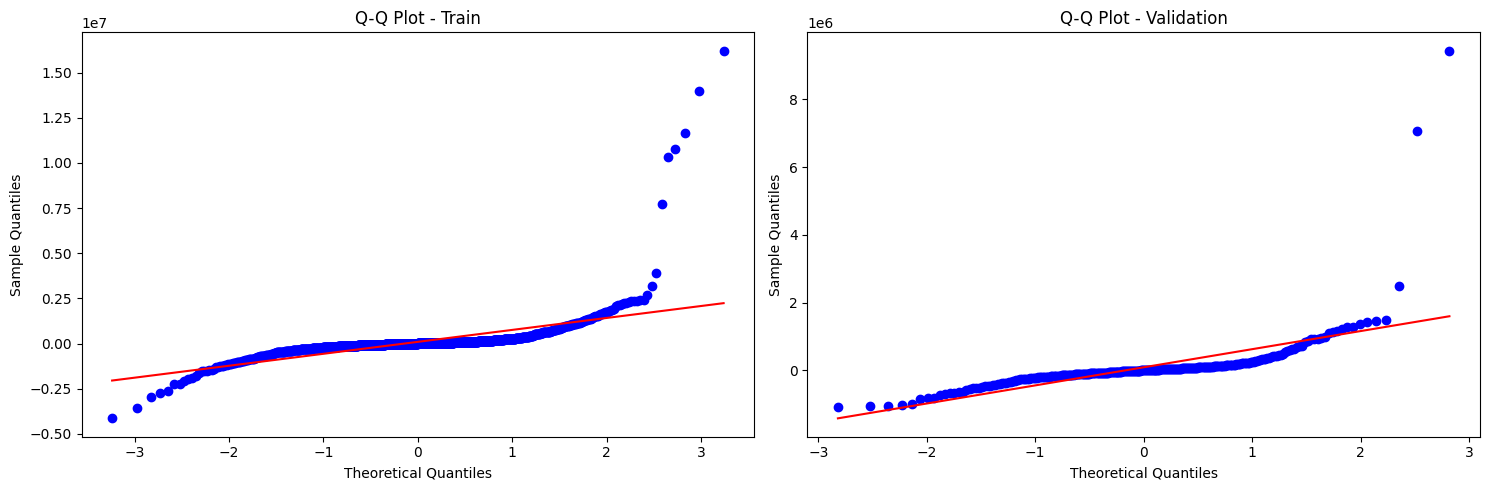

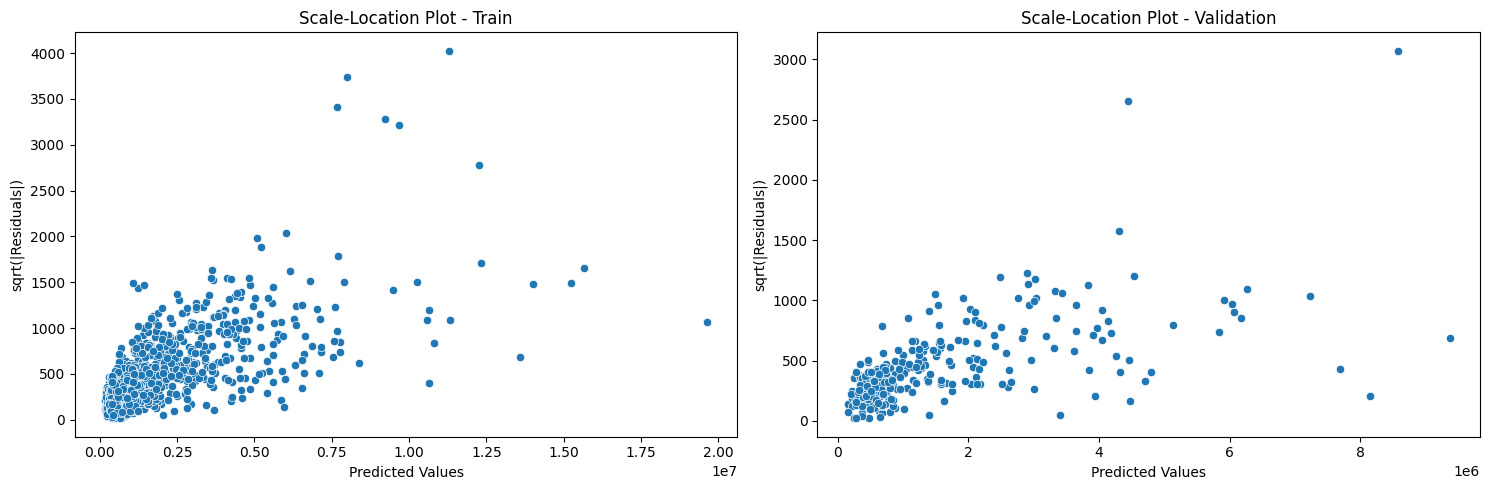

['Max Power BHP',
 'Year',
 'Max Torque Nm',
 'Transmission_Manual',
 'Length',
 'Fuel Tank Capacity',
 'Seating Capacity',
 'Max Torque RPM',
 'Kilometer',
 'Width',
 'Fuel Type_Diesel',
 'Fuel Type_Others',
 'Fuel Type_Petrol',
 'Drivetrain_FWD',
 'Drivetrain_RWD',
 'Height',
 'Max Power RPM',
 'Owner',
 'Seller Type_Corporate',
 'Seller Type_Individual']

In [53]:
testing(linear=False, 
        deg=2,
        auto_selection=True, 
        model_type=PolynomialRegression)

### Mixed regression (degree = 2, đã tạo interaction terms)
$$ y = \beta_0 + \sum_{j=1}^{p} \beta_j x_j + \sum_{j=1}^{p} \sum_{d=2}^D \beta_{jd} x_j^d + \sum_{j=1}^{p} \sum_{k>j}^{p} \beta_{jk} (x_j \times x_k) + \varepsilon \\ \varepsilon : \text{Error term (residuals) - Represents the unexplained variation} \\ \text{assumed to follow normal distribution with mean 0 and constant variance $\sigma^2$}
\\ p : \text{Number of predictor variables (features) in the dataset}
\\ D : \text{Maximum polynomial degree considered in the model (controlled by self.degree in the code)} $$

#### Create interaction terms

Adjusted log r^2 on transformed target: 0.9699542108969088
Eliminated features: {'Max Power BHP*Fuel Type_Petrol', 'Height*Seller Type_Individual', 'Length*Width', 'Year*Max Torque Nm', 'Height*Fuel Type_Diesel', 'Engine*Seating Capacity', 'Drivetrain_FWD*Seller Type_Corporate', 'Width*Seating Capacity', 'Seller Type_Corporate*Transmission_Manual', 'Transmission_Manual*Seating Capacity', 'Seller Type_Individual*Seating Capacity', 'Width*Fuel Type_Others', 'Kilometer*Max Power BHP', 'Kilometer^2', 'Max Power RPM*Height', 'Max Torque Nm*Fuel Type_Petrol', 'Owner*Seating Capacity', 'Width*Max Torque Nm', 'Fuel Type_Diesel^2', 'Drivetrain_FWD*Transmission_Manual', 'Length*Fuel Type_Others', 'Owner*Drivetrain_FWD', 'Width*Drivetrain_FWD', 'Owner*Fuel Type_Diesel', 'Fuel Tank Capacity*Fuel Type_Diesel', 'Max Torque RPM*Seating Capacity', 'Fuel Tank Capacity*Fuel Type_Others', 'Drivetrain_RWD*Seller Type_Individual', 'Fuel Type_Diesel*Transmission_Manual', 'Max Power RPM*Drivetrain_RWD', 'Max

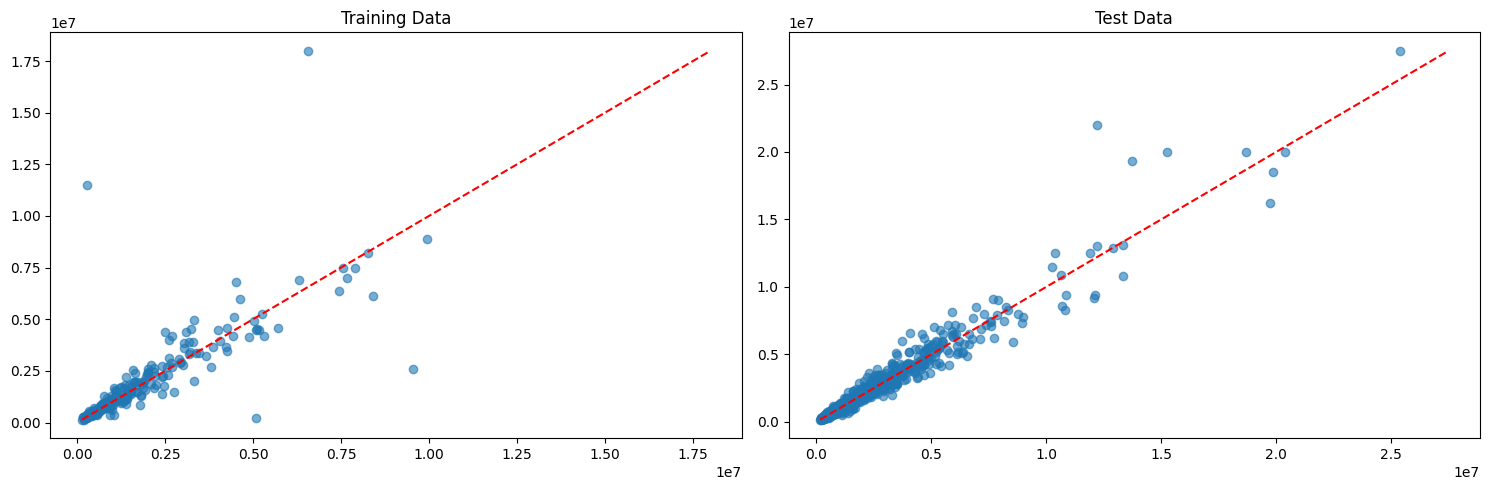

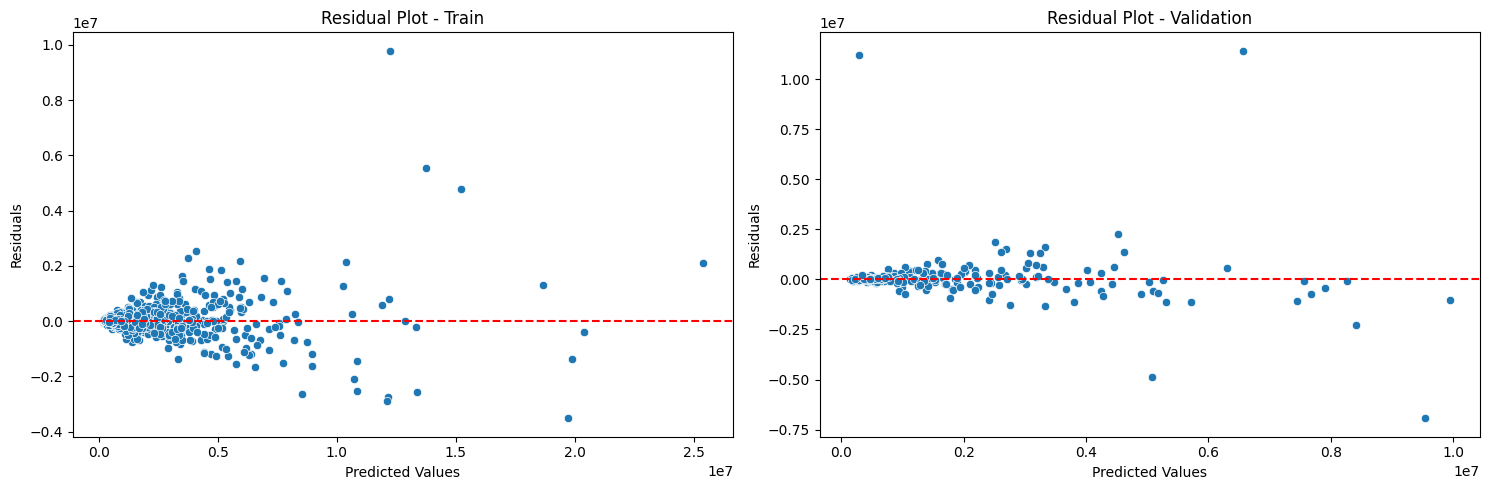

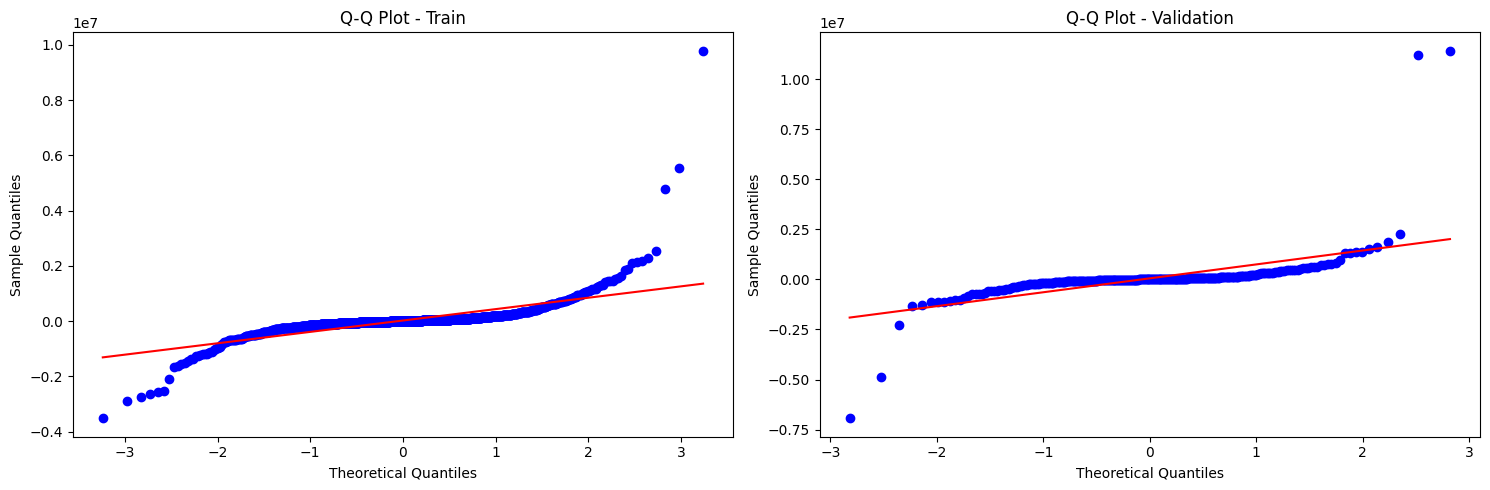

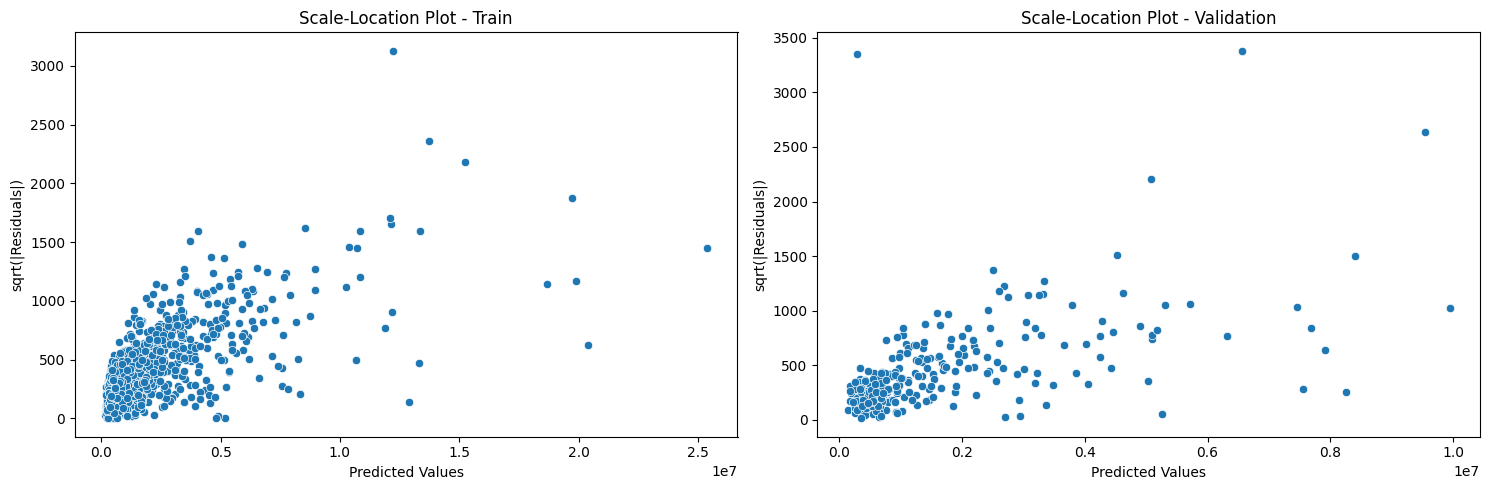

['Max Power BHP',
 'Year',
 'Max Power RPM',
 'Transmission_Manual',
 'Width',
 'Seating Capacity',
 'Length',
 'Drivetrain_FWD',
 'Drivetrain_RWD',
 'Height',
 'Fuel Tank Capacity',
 'Engine',
 'Fuel Type_Diesel',
 'Fuel Type_Others',
 'Fuel Type_Petrol',
 'Kilometer',
 'Owner',
 'Max Torque RPM',
 'Max Torque Nm',
 'Seller Type_Corporate',
 'Seller Type_Individual']

In [54]:
import warnings
from pandas.errors import PerformanceWarning
warnings.filterwarnings("ignore", category=PerformanceWarning)

from modelling.Model import MixedRegression
testing(linear=False,
        deg=2,
        auto_selection=True, 
        model_type=MixedRegression) 

### Choosing the most generalized model for prediction
After modeling 4 hypothesis models on the train dataset and tested them, **insert stats and figs** here.
We choose to discard model 1 and 3 because of low performance, and model 4 for overfitting, we've decided to go with model 2 because of its simplicity and generalized ability.
  

In [55]:
subcols = testing(auto_selection=True, plot=False)
model.fit(train_df[subcols], train_df['Price'])

Adjusted log r^2 on transformed target: 0.9235374565651404
Eliminated features: {'Engine', 'Price'}
Chosed columns:  ['Max Power BHP', 'Year', 'Length', 'Transmission_Manual', 'Max Power RPM', 'Fuel Tank Capacity', 'Seating Capacity', 'Drivetrain_FWD', 'Drivetrain_RWD', 'Kilometer', 'Width', 'Fuel Type_Diesel', 'Fuel Type_Others', 'Fuel Type_Petrol', 'Max Torque RPM', 'Height', 'Max Torque Nm', 'Seller Type_Corporate', 'Seller Type_Individual', 'Owner']
Total columns:  20


# Dự đoán trên file csv được đọc vào

In [57]:
data_path = 'test.csv'
test_data = pd.read_csv(data_path)
test_data = clean_data(test_data)
y = test_data['Price']

test_data = preprocessor.transform(test_data)
test_data = pd.DataFrame(test_data, columns=feature_names)

model.predict(test_data[subcols])

y_pred = np.exp(model.predict(test_data[subcols]))
print('Test r^2: ', r2_score(y, y_pred))
print('Test MAE: ', f"{mean_absolute_error(y, y_pred):.3e}")
print('Test MSE: ', f"{mean_squared_error(y, y_pred):.3e}")

Test r^2:  0.8371636420307725
Test MAE:  3.561e+05
Test MSE:  9.232e+11
